In [190]:
from scipy import stats
from tqdm import tqdm
from dart_fss import get_corp_list
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
import dart_fss as dart
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import os
import time

load_dotenv()

API_KEY = os.getenv("API_KEY")

dart.set_api_key(api_key=API_KEY)

# 모든 상장된 기업 리스트 불러오기
corp_list = get_corp_list()

In [191]:
industry = "도매및소매업" 

df_kospi = pd.read_excel(f"업종별_기업리스트/{industry}_KOSPI.xlsx")
df_kosdaq = pd.read_excel(f"업종별_기업리스트/{industry}_KOSDAQ.xlsx")

df_total = pd.concat([df_kospi, df_kosdaq], ignore_index=True)
df_total = df_total.drop_duplicates()
df_total["업종구분"] = industry

corp_name_list = list(df_total["회사명"])
print(f"{industry} {len(corp_name_list)}개 기업 목록을 리스트로 저장했습니다.")
# corp_name_list

도매및소매업 172개 기업 목록을 리스트로 저장했습니다.


c:\Users\82107\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\82107\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [192]:
target_ratio = [
    "자기자본비율", "부채비율", "유동비율", "유동부채비율", "비유동부채비율", "비유동비율", "금융비용부담률",
    "재무레버리지", "비유동적합률", "유동자산구성비율", "재고자산구성비율", "유동자산/비유동자산비율", "재고자산/유동자산비율", # 안정성지표
]

idx_cl_code_dict = {
    "M220000": "안정성지표"
}

corp_name_dict = {}

for corp in corp_name_list:
    name = corp_list.find_by_corp_name(corp, exactly=True)
    if name:
        corp_code = str(name[0])[1:9]
    else:
        print(f"{corp}(은)는 다중회사가 아니므로 건너뜁니다.")
        continue
    corp_name_dict[f"{corp}"] = corp_code

print(f"회사는 총 {len(corp_name_dict)}개입니다.")

# 기업별 종합 row
corp_data_dict = {}

회사는 총 172개입니다.


In [193]:
# --- API 요청 URL 및 파라미터 ---
for idx_cl_code, 지표분류 in idx_cl_code_dict.items():

    tqdm.write(f"=== {지표분류} 요청 중 ===")

    for corp_name, corp_code in tqdm(corp_name_dict.items(), desc=f"{지표분류} 수집 중", unit="개"):
        base_url = "https://opendart.fss.or.kr/api/fnlttCmpnyIndx.json"
        params = {
            'crtfc_key': API_KEY,
            'corp_code': corp_code, # 대상 기업 코드
            'bsns_year': "2024", # 회계연도
            'reprt_code': "11011", # 사업보고서
            'idx_cl_code': idx_cl_code,
        }

        # --- GET 요청 보내기 ---
        try:
            response = requests.get(base_url, params=params)
            
            # --- 응답 확인 ---
            # HTTP 상태 코드가 200 (OK)인지 확인
            if response.status_code == 200:
                
                data = json.loads(response.text)

                # 한 기업 당 하나의 행 생성
                if corp_name not in corp_data_dict:
                    corp_data_dict[corp_name] = {
                        "기업명": corp_name,
                    }

                for item in data.get("list", []):
                    idx_nm = item.get("idx_nm")
                    if idx_nm in target_ratio:
                        corp_data_dict[corp_name][idx_nm] = item.get("idx_val")
                
            else:
                tqdm.write(f"HTTP 오류 {response.status_code} - {corp_name}")

            time.sleep(0.3)

        except requests.exceptions.RequestException as e:
            tqdm.write(f"{corp_name} 요청 중 에러 발생: {e}")

# DataFrame 생성
df = pd.DataFrame(list(corp_data_dict.values()))

df.to_csv("주요지표.csv", index=False, encoding='utf-8-sig')

=== 안정성지표 요청 중 ===


안정성지표 수집 중: 100%|██████████| 172/172 [01:09<00:00,  2.48개/s]


In [194]:
df = pd.read_csv("주요지표.csv")

filtered_df = df.dropna(subset=target_ratio, how='all')

print(f"원본 행 개수: {len(df)}")
print(f"필터링 후 행 개수: {len(filtered_df)}")

filtered_df.to_csv("주요지표_누락처리.csv", index=False, encoding='utf-8-sig')

원본 행 개수: 172
필터링 후 행 개수: 149


In [195]:
# 데이터 전처리
z_df = filtered_df.copy()

for col in target_ratio:
    z_df[col] = (
        z_df[col]
        .astype(str)
        .str.replace(",", "")   # 쉼표 제거
        .str.replace("%", "")   # 퍼센트 제거
        .replace("None", np.nan)
        .replace("", np.nan)
        .astype(float)
    )

# 정규분포화
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z_df[target_ratio])

# 다시 DataFrame으로 변환
z_scaled_df = pd.DataFrame(z_scaled, columns=target_ratio, index=z_df.index)
z_scaled_df = z_scaled_df.fillna(0)
z_scaled_df["기업명"] = filtered_df.loc[z_df.index, "기업명"].values
z_scaled_df.to_csv("주요지표_Z.csv", index=False, encoding='utf-8-sig')

In [196]:
def adaptive_score(series_raw, series_z, std_threshold=100, z_thresh=2.5):
    """
    지표별 표준편차에 따라 점수화 방식을 다르게 적용
    - 표준편차가 크면 Z-score 기반 극단값 감지 및 점수화
    - 작으면 분위수 기반 점수화

    - series_raw: 원본 데이터 (filtered_df[col])
    - series_z: Z-score로 변환된 데이터 (z_scaled_df[col])
    """

    std = series_raw.std()
    scores = pd.Series(0, index=series_raw.index)

    # Z-score 방식
    if std > std_threshold:

        # -z_thresh ~ +z_thresh 안쪽만 정상 구간
        mask = (series_z >= -z_thresh) & (series_z <= z_thresh)

        # 정상구간에서 분위 점수 (5분위)
        try:
            bins = pd.qcut(series_z[mask], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
            scores.loc[mask] = bins.astype(int)
        except ValueError:
            # unique 값 부족할 경우 중간점수(3) 부여
            scores.loc[mask] = 3

    # 분위수 방식 (표준편차 작음)
    else:
        q_low = series_raw.quantile(0.05)
        q_high = series_raw.quantile(0.95)
        mask = (series_raw >= q_low) & (series_raw <= q_high)

        try:
            bins = pd.qcut(series_raw[mask], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
            scores.loc[mask] = bins.astype(int)
        except ValueError:
            scores.loc[mask] = 3

    return scores

In [197]:
reverse_ratio = [
    "부채비율", "유동부채비율", "비유동부채비율", "비유동비율", "비유동적합률",
    "금융비용부담률", "재무레버리지", "재고자산구성비율", "재고자산/유동자산비율",
]

for col in reverse_ratio:
    z_scaled_df[col] = z_scaled_df[col] * -1

scored_df = z_scaled_df[["기업명"]].copy()

for col in target_ratio:
    scored_df[col + "_점수"] = adaptive_score(filtered_df[col], z_scaled_df[col])

scored_df.to_csv("주요지표_분위점수_극단값.csv", index=False, encoding='utf-8-sig')

In [198]:
short_term_metrics = [
    "유동비율", "유동부채비율", "유동자산구성비율",
    "재고자산구성비율", "유동자산/비유동자산비율", "재고자산/유동자산비율"
]

long_term_metrics = [
    "자기자본비율", "부채비율", "비유동부채비율",
    "비유동비율", "금융비용부담률", "재무레버리지", "비유동적합률"
]

short_term_score_cols = [col + "_점수" for col in short_term_metrics]
long_term_score_cols = [col + "_점수" for col in long_term_metrics]

# 개별 합산
scored_df["단기안정성점수"] = scored_df[short_term_score_cols].sum(axis=1)
scored_df["장기안정성점수"] = scored_df[long_term_score_cols].sum(axis=1)

# 총합 점수
scored_df["총합점수"] = (
    scored_df["단기안정성점수"] + scored_df["장기안정성점수"]
)

# 종합순위
scored_df["종합순위"] = scored_df["총합점수"].rank(method='min', ascending=False).astype(int)

scored_df.to_csv("주요지표_합산.csv", index=False, encoding='utf-8-sig')

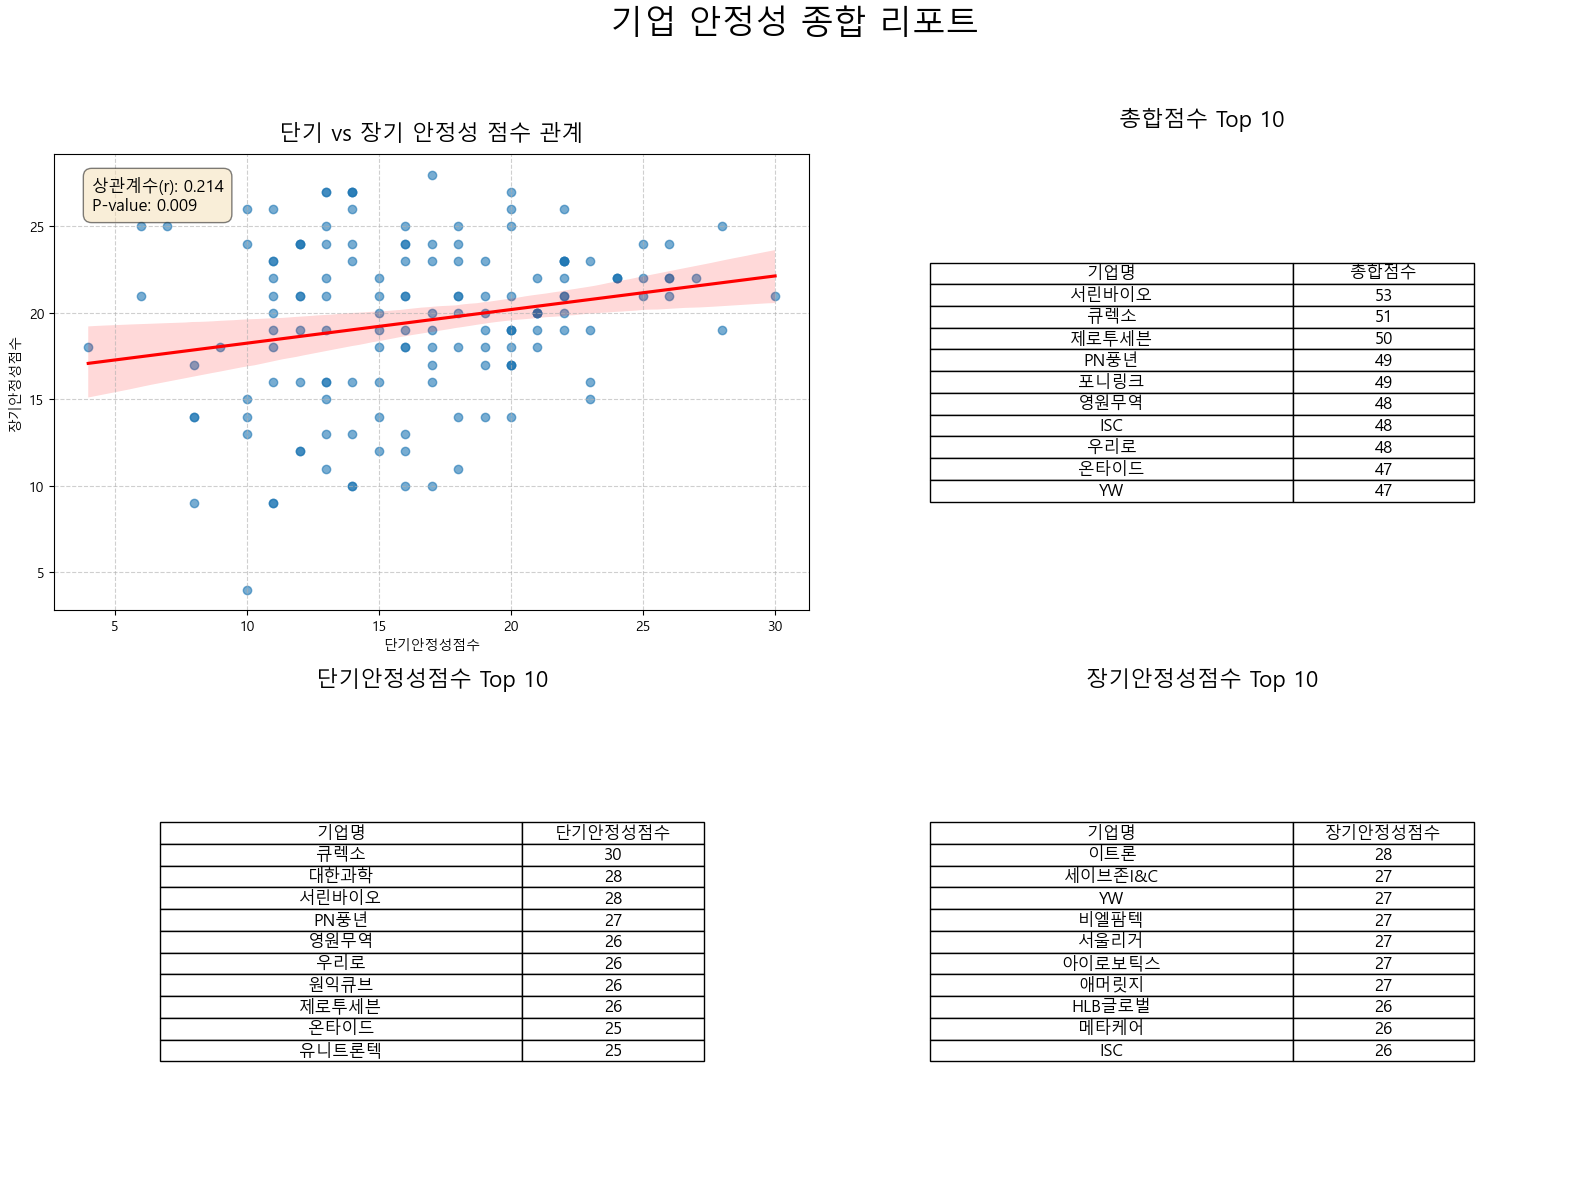

종합 리포트가 '종합_리포트.png' 파일로 저장되었습니다.


In [199]:
# 각 점수별 상위 10개 기업 추출
top10_total = scored_df.nlargest(10, '총합점수')[['기업명', '총합점수']].reset_index(drop=True)
top10_short = scored_df.nlargest(10, '단기안정성점수')[['기업명', '단기안정성점수']].reset_index(drop=True)
top10_long = scored_df.nlargest(10, '장기안정성점수')[['기업명', '장기안정성점수']].reset_index(drop=True)

# 회귀분석: 상관계수 및 p-value 계산
corr, p_value = stats.pearsonr(scored_df['단기안정성점수'], scored_df['장기안정성점수'])
corr_text = f"상관계수(r): {corr:.3f}\nP-value: {p_value:.3f}"

# 전체 보고서 레이아웃
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('기업 안정성 종합 리포트', fontsize=24, y=0.98)

# (0, 0) 위치: 스캐터 플롯 및 회귀선
ax_scatter = axs[0, 0]
sns.regplot(
    data=scored_df,
    x='단기안정성점수',
    y='장기안정성점수',
    ax=ax_scatter,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
ax_scatter.set_title('단기 vs 장기 안정성 점수 관계', fontsize=16, pad=10)
ax_scatter.grid(True, linestyle='--', alpha=0.6)
# 회귀분석 결과 텍스트 추가
ax_scatter.text(0.05, 0.95, corr_text, transform=ax_scatter.transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# (0, 1) 위치: 총합점수 상위 10개 기업
ax_total = axs[0, 1]
ax_total.axis('off') # 축 숨기기
ax_total.set_title('총합점수 Top 10', fontsize=16, pad=20)
table_total = ax_total.table(
    cellText=top10_total.values,
    colLabels=top10_total.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4, 0.2]
)
table_total.auto_set_font_size(False)
table_total.set_fontsize(12)
table_total.scale(1.2, 1.2)

# (1, 0) 위치: 단기안정성점수 상위 10개 기업
ax_short = axs[1, 0]
ax_short.axis('off')
ax_short.set_title('단기안정성점수 Top 10', fontsize=16, pad=20)
table_short = ax_short.table(
    cellText=top10_short.values,
    colLabels=top10_short.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4, 0.2]
)
table_short.auto_set_font_size(False)
table_short.set_fontsize(12)
table_short.scale(1.2, 1.2)

# (1, 1) 위치: 장기안정성점수 상위 10개 기업
ax_long = axs[1, 1]
ax_long.axis('off')
ax_long.set_title('장기안정성점수 Top 10', fontsize=16, pad=20)
table_long = ax_long.table(
    cellText=top10_long.values,
    colLabels=top10_long.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4, 0.2]
)
table_long.auto_set_font_size(False)
table_long.set_fontsize(12)
table_long.scale(1.2, 1.2)


# --- 저장 및 출력 ---
plt.tight_layout(rect=[0, 0, 1, 0.95]) # suptitle과 겹치지 않도록 조정
plt.savefig('종합_리포트.png', dpi=300, bbox_inches='tight')
plt.show()

print("종합 리포트가 '종합_리포트.png' 파일로 저장되었습니다.")
